<a href="https://colab.research.google.com/github/Ahmadar91/ML/blob/main/Lab_4_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [9]:
%matplotlib inline

In [3]:
%pip install matplotlib 
%pip install pandas 
%pip install torch 
%pip install torchvision


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math

In [41]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=False
)

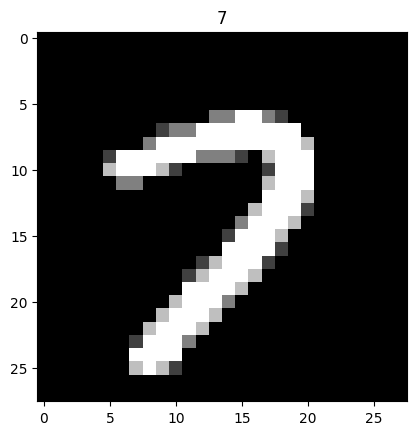

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

image = image * 0.5 + 0.5

image = image.numpy()

plt.imshow(image.squeeze(), cmap="gray")

plt.title(str(label.item()))

plt.show()

In [42]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        print("kernel size", self.kernel_size)
        input_size = 28
        output_channels_value = 16
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=output_channels_value,
            kernel_size=self.kernel_size,
        )
        self.pool = nn.MaxPool2d(self.kernel_size)
        conv_out_size = (input_size - self.kernel_size) + 1
        print(f"conv_out_size: {conv_out_size}")
        pool_out_size = ((conv_out_size - self.kernel_size) // self.kernel_size) + 1
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = (
            output_channels_value * pool_out_size * pool_out_size
        )
        print("input_size_after_conv_and_pool", input_size_after_conv_and_pool)
        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [43]:
trainAccuracy = list()
testAccuracy = list()

model = MyCNN(5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

kernel size 5
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 256


In [44]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    return train_accuracy


def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy


for epoch in range(n_epochs):
    train_accuracy = train(model, train_loader, criterion, optimizer)
    trainAccuracy.append(train_accuracy)

    test_accuracy = test(model, test_loader)
    testAccuracy.append(test_accuracy)

    print(
        f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
    )

print("Finished Training")

Epoch 1, Train Accuracy: 82.48%, Test Accuracy: 94.96%
Epoch 2, Train Accuracy: 95.77%, Test Accuracy: 96.53%
Epoch 3, Train Accuracy: 96.70%, Test Accuracy: 97.26%
Epoch 4, Train Accuracy: 97.17%, Test Accuracy: 97.51%
Epoch 5, Train Accuracy: 97.47%, Test Accuracy: 97.52%
Epoch 6, Train Accuracy: 97.69%, Test Accuracy: 97.73%
Epoch 7, Train Accuracy: 97.83%, Test Accuracy: 97.87%
Epoch 8, Train Accuracy: 97.99%, Test Accuracy: 97.97%
Epoch 9, Train Accuracy: 98.09%, Test Accuracy: 98.08%
Epoch 10, Train Accuracy: 98.18%, Test Accuracy: 97.97%
Finished Training


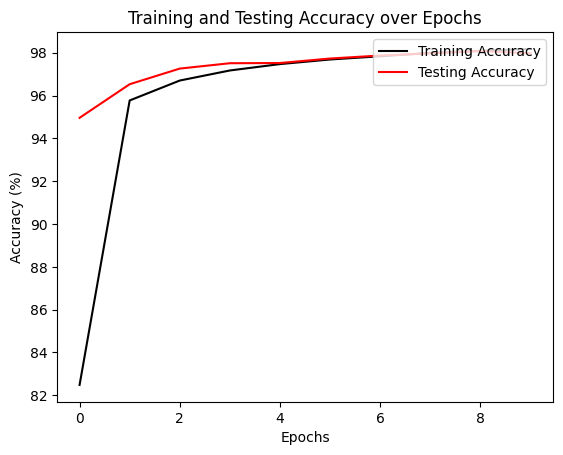

In [45]:
plt.plot(trainAccuracy, "k", label="Training Accuracy")
plt.plot(testAccuracy, "r", label="Testing Accuracy")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")

plt.show()

2
conv_out_size: 27
pool_out_size: 13
Epoch 1, Train Accuracy: 85.04%, Test Accuracy: 91.37%
Epoch 2, Train Accuracy: 92.20%, Test Accuracy: 93.68%
Epoch 3, Train Accuracy: 94.30%, Test Accuracy: 94.84%
Epoch 4, Train Accuracy: 95.83%, Test Accuracy: 95.94%
Epoch 5, Train Accuracy: 96.63%, Test Accuracy: 96.85%
Epoch 6, Train Accuracy: 97.19%, Test Accuracy: 97.09%
Epoch 7, Train Accuracy: 97.57%, Test Accuracy: 97.19%
Epoch 8, Train Accuracy: 97.78%, Test Accuracy: 97.36%
Epoch 9, Train Accuracy: 97.98%, Test Accuracy: 97.48%
Epoch 10, Train Accuracy: 98.15%, Test Accuracy: 97.70%
Epoch 11, Train Accuracy: 98.28%, Test Accuracy: 97.54%
Epoch 12, Train Accuracy: 98.39%, Test Accuracy: 97.62%
Epoch 13, Train Accuracy: 98.54%, Test Accuracy: 97.83%
Epoch 14, Train Accuracy: 98.59%, Test Accuracy: 97.95%
Epoch 15, Train Accuracy: 98.72%, Test Accuracy: 97.99%
Epoch 16, Train Accuracy: 98.80%, Test Accuracy: 97.88%
Epoch 17, Train Accuracy: 98.86%, Test Accuracy: 98.06%
Epoch 18, Train Acc

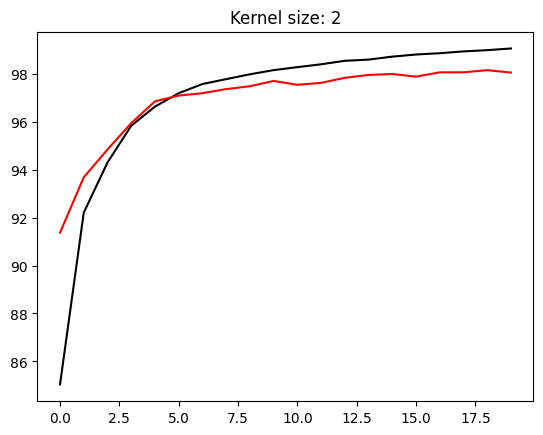

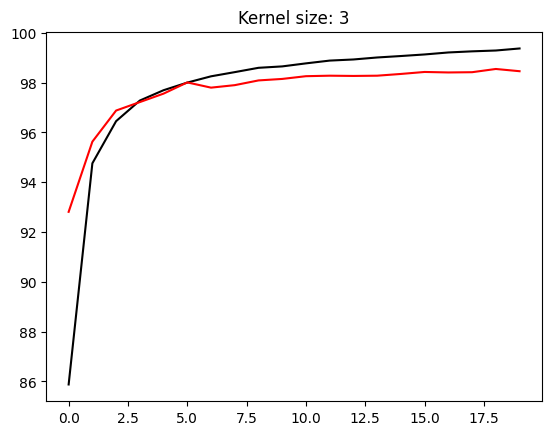

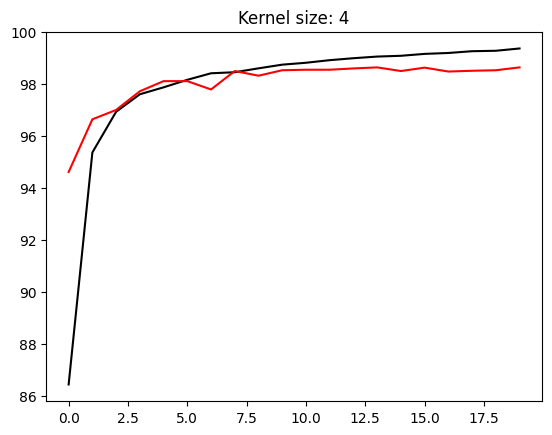

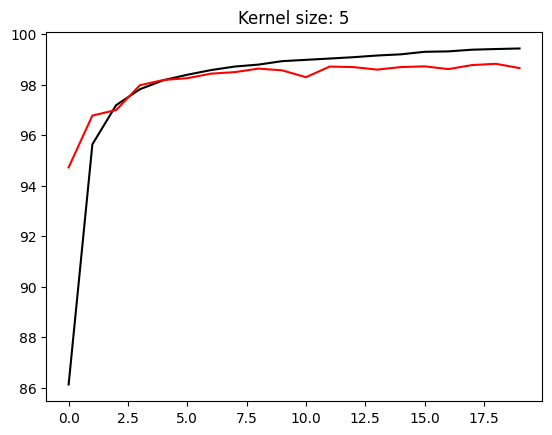

In [51]:
kernelSizes = [2, 3, 4, 5]

for kernelSize in kernelSizes:
    trainAccuracy = list()
    testAccuracy = list()
    # instantiate your CNN using kernel size
    trainAccuracy = list()
    testAccuracy = list()

    model = MyCNN(kernelSize)
    # define optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    # train and test - you can copy the code
    for epoch in range(n_epochs):
        train_accuracy = train(model, train_loader, criterion, optimizer)
        trainAccuracy.append(train_accuracy)

        test_accuracy = test(model, test_loader)
        testAccuracy.append(test_accuracy)

        print(
            f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
        )

    print("Finished Training")
    # now plot this
    plt.plot(trainAccuracy, "k", label="Training Accuracy")
    plt.plot(testAccuracy, "r", label="Testing Accuracy")
    title("Kernel size: " + str(kernelSize))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper right")
    plt.show()